In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn, optim
import numpy as np

# Autoencoder

In [2]:
result_folder = 'autoencoder_results'
num_input = 96 * 54

In [3]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = read_image(img_name)
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [5]:
dataset = ImageFolderDataset(root_dir='images', transform=transform)
dataloader = DataLoader(dataset, batch_size=64)

Feature batch shape: torch.Size([64, 1, 54, 96])
Feature [0] batch shape: torch.Size([1, 54, 96])


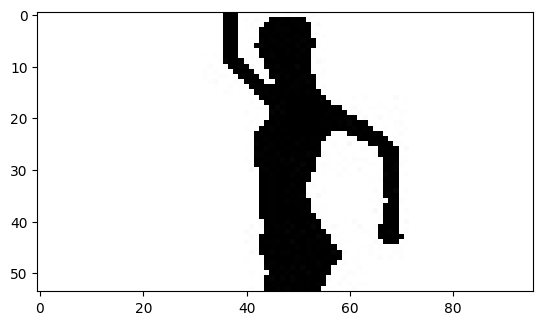

In [6]:
features, _ = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Feature [0] batch shape: {features[0].shape}")

img = features[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()

In [31]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_input, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, num_input),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [32]:
autoencoder_model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters())

In [33]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
autoencoder_model.to(device)
print(device)

mps


In [34]:
num_epochs = 100

In [7]:
save_dir = 'autoencoder_results'
os.makedirs(save_dir, exist_ok=True)
# results_file = os.path.join(save_dir, 'training_results.csv')

In [36]:
with open(results_file, 'w') as f:
    f.write('Epoch,Loss\n')  

In [37]:
print('====Training start====')
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in dataloader:

        data = data.to(device)        
        image = torch.reshape(data,(-1, num_input))

        optimizer.zero_grad()
        
        output = autoencoder_model(image)
        loss = loss_function(output, image)

        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    
    if epoch % 5 == 0:
        torch.save(autoencoder_model.state_dict(), os.path.join(save_dir, f'autoencoder_epoch_{epoch+1}.pth'))
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
        with open(results_file, 'a') as f:
            f.write(f'{epoch+1},{train_loss:.4f}\n')
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 34.2997
====> Epoch: 5 Average loss: 18.1006
====> Epoch: 10 Average loss: 13.9563
====> Epoch: 15 Average loss: 11.7860
====> Epoch: 20 Average loss: 10.6565
====> Epoch: 25 Average loss: 9.7192
====> Epoch: 30 Average loss: 8.8752
====> Epoch: 35 Average loss: 8.7959
====> Epoch: 40 Average loss: 8.1806
====> Epoch: 45 Average loss: 7.9964
====> Epoch: 50 Average loss: 8.0153
====> Epoch: 55 Average loss: 7.4179
====> Epoch: 60 Average loss: 7.5768
====> Epoch: 65 Average loss: 7.1941
====> Epoch: 70 Average loss: 6.9779
====> Epoch: 75 Average loss: 6.8414
====> Epoch: 80 Average loss: 6.8039
====> Epoch: 85 Average loss: 7.0510
====> Epoch: 90 Average loss: 6.4872
====> Epoch: 95 Average loss: 6.5055
====Training finish====


torch.Size([1, 5184])
torch.Size([54, 96])


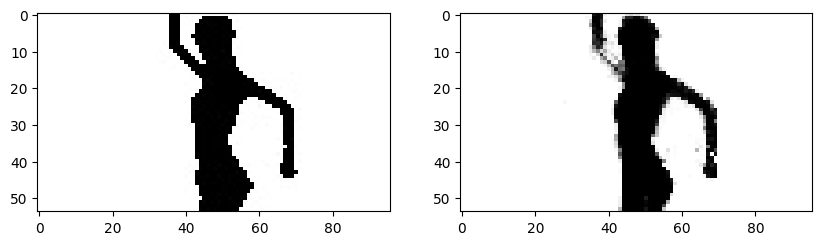

In [38]:
inputs, _ = next(iter(dataloader))

inputs = inputs.to(device)
inputs = inputs[0].squeeze()
inputs_example = torch.reshape(inputs,(-1, num_input))

outputs = autoencoder_model(inputs_example)
print(outputs.shape)

outputs = torch.reshape(outputs,(1,54,96)).cpu().detach().squeeze()
# outputs = outputs.detach()

print(outputs.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(inputs.cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(outputs, cmap="gray")
plt.show()

torch.Size([1, 5184])
torch.Size([54, 96])


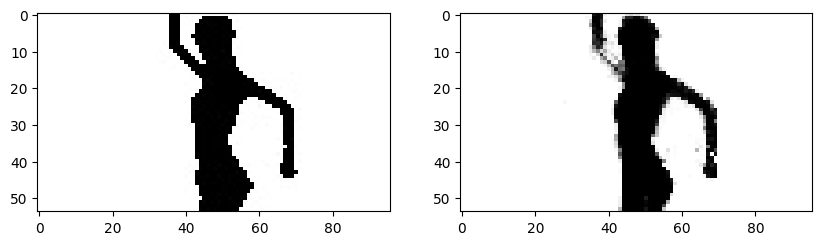

torch.Size([1, 5184])
torch.Size([54, 96])


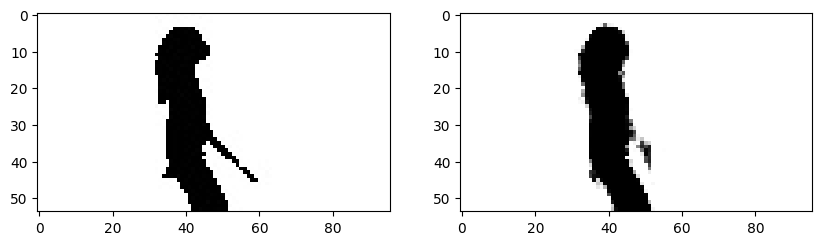

torch.Size([1, 5184])
torch.Size([54, 96])


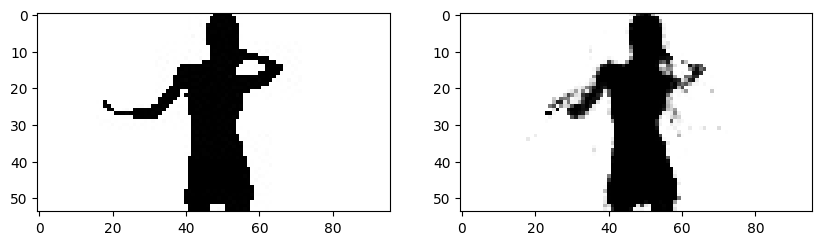

torch.Size([1, 5184])
torch.Size([54, 96])


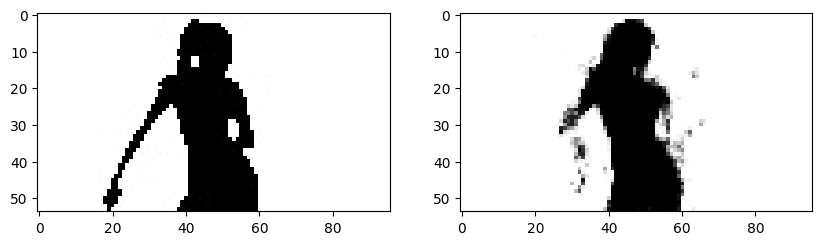

torch.Size([1, 5184])
torch.Size([54, 96])


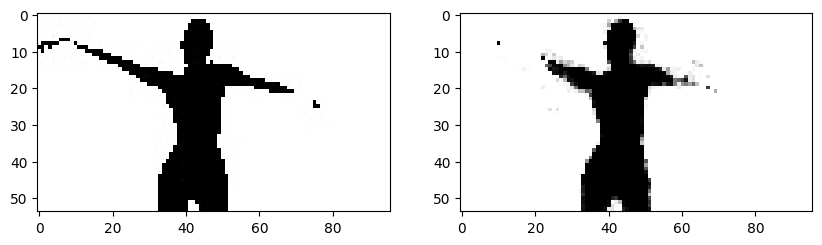

In [39]:
inputs, _ = next(iter(dataloader))

for i in range(5):
    inputs = inputs.to(device)
    inputs_example = inputs[i].squeeze()
    inputs_example_reshape = torch.reshape(inputs_example,(-1, num_input))
    
    outputs = autoencoder_model(inputs_example_reshape)
    print(outputs.shape)
    
    outputs = torch.reshape(outputs,(1,54,96)).cpu().detach().squeeze()
    # outputs = outputs.detach()
    
    print(outputs.shape)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(inputs_example.cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(outputs, cmap="gray")
    plt.show()

In [9]:
import pandas
df = pandas.read_csv(results_file)

NameError: name 'results_file' is not defined

In [41]:
df.head()

,Epoch,Loss
0,1,34.2997
1,6,18.1006
2,11,13.9563
3,16,11.7860
4,21,10.6565


<Axes: xlabel='Epoch'>

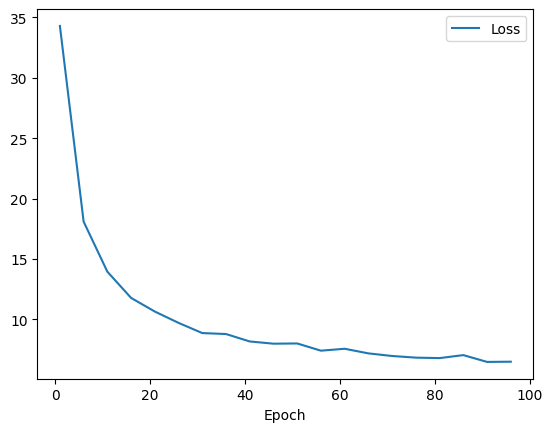

In [42]:
df.plot(x = 'Epoch', y = 'Loss')

# Prepare image vectors

In [11]:
output_file_name = 'encoded_vectors.csv'
encoded_vectors = os.path.join(save_dir, output_file_name)

In [44]:
with open(encoded_vectors, 'w') as f:
    f.write('file_name,encode_vector\n')
    idx = 0
    for data in dataloader:
        images, filenames = data
        for img, filename in zip(images, filenames):
            img = img.to(device)
            with torch.no_grad():
                encoded = autoencoder_model.encoder(img)
            
            encoded_vector = encoded.cpu().numpy().flatten()
            encoded_vector_str = ','.join(map(str, encoded_vector))
            f.write(f'{filename},"{encoded_vector_str}"\n')

            if idx % 5000 == 0:
                print(f"processed: {idx}")
            idx += 1
print(f"Finished")       

processed: 0
processed: 5000
processed: 10000
processed: 15000
processed: 20000
processed: 25000
processed: 30000
processed: 35000
processed: 40000
processed: 45000
Finished


In [12]:
df = pandas.read_csv(encoded_vectors, dtype={'file_name':str, 'encode_vector':str})
df.head()

,file_name,encode_vector
0,image_27358.jpg,"3.827737,8.89476,-4.928508,9.988823,8.324108,7..."
1,image_07088.jpg,"-8.903427,-2.068553,7.6056404,0.6711218,0.3637..."
2,image_30624.jpg,"-3.6697567,6.0375023,-9.651558,-12.386952,5.37..."
3,image_11832.jpg,"5.0474777,-0.2707529,-6.52372,8.987112,-0.7738..."
4,image_20437.jpg,"-0.7364535,-6.6709104,11.990046,-5.7974267,-14..."


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47933 entries, 0 to 47932
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_name      47933 non-null  object
 1   encode_vector  47933 non-null  object
dtypes: object(2)
memory usage: 749.1+ KB


In [13]:
def makeArray(text):
    return np.fromstring(text,sep=',')

In [14]:
df['encode_vector'] = df['encode_vector'].apply(makeArray)

In [15]:
df.head()

,file_name,encode_vector
0,image_27358.jpg,"[3.827737, 8.89476, -4.928508, 9.988823, 8.324..."
1,image_07088.jpg,"[-8.903427, -2.068553, 7.6056404, 0.6711218, 0..."
2,image_30624.jpg,"[-3.6697567, 6.0375023, -9.651558, -12.386952,..."
3,image_11832.jpg,"[5.0474777, -0.2707529, -6.52372, 8.987112, -0..."
4,image_20437.jpg,"[-0.7364535, -6.6709104, 11.990046, -5.7974267..."


In [16]:
df = df.sort_values(by=['file_name'])

In [17]:
df.head()

,file_name,encode_vector
24157,image_00000.jpg,"[-0.37974793, 2.5544536, -12.007536, 8.731526,..."
26829,image_00001.jpg,"[-2.201338, -3.0241635, -10.794367, 10.276288,..."
29740,image_00002.jpg,"[1.2250495, -1.7532852, 6.2355523, 8.763134, -..."
27275,image_00003.jpg,"[1.5669496, -5.325438, 16.958895, 2.889531, -8..."
35641,image_00004.jpg,"[0.91779304, -1.819226, 9.982983, 7.9047503, -..."


# RNN

In [52]:
# df - dataframe with vectors

In [18]:
input_dim = 128  # размер входного вектора
timesteps = 10   # длина временного ряда, используемого для предсказания
num_units = 128  # количество блоков LSTM в первом слое
num_units2 = 64  # количество блоков LSTM во втором слое
dropout_rate = 0.2  # доля выключаемых нейронов для Dropout слоя
batch_size = 64  # размер батча
epochs = 100     # количество эпох для обучения
learning_rate = 0.001  # скорость обучения

In [19]:
results_rnn_file = os.path.join(save_dir, 'training_rnn_results.csv')

In [55]:
with open(results_rnn_file, 'w') as f:
    f.write('Epoch,Loss\n')  

In [28]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
# X[i] - [from i to i + timesteps]
# y[i] - i + timesteps element (target value )

In [30]:
def create_dataset(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

In [31]:
data = np.stack(df['encode_vector'].values)
X, y = create_dataset(data, timesteps)

In [32]:
dataset = TimeSeriesDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_dim, num_units):
        super(SimpleLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, num_units, batch_first=True)
        self.fc = nn.Linear(num_units, input_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [49]:
lstm_model = SimpleLSTMModel(input_dim, num_units)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [50]:
lstm_model.to(device)

SimpleLSTMModel(
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=128, bias=True)
)

In [51]:
epochs = 30
print('====Training start====')
for epoch in range(epochs):
    train_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()

        inputs = inputs.to(device)  

        outputs = lstm_model(inputs)
        loss = criterion(outputs.cpu(), targets)
        loss.backward()
        
        train_loss += loss.item()        
        optimizer.step()
    
    if epoch % 5 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
        with open(results_rnn_file, 'a') as f:
            f.write(f'{epoch+1},{train_loss:.4f}\n')
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 42722.7835
====> Epoch: 5 Average loss: 23340.0585
====> Epoch: 10 Average loss: 21530.0199
====> Epoch: 15 Average loss: 20806.8361
====> Epoch: 20 Average loss: 20379.9722
====> Epoch: 25 Average loss: 20111.3777
====Training finish====


In [52]:
df.iloc[1]

file_name                                          image_00001.jpg
encode_vector    [-2.201338, -3.0241635, -10.794367, 10.276288,...
Name: 26829, dtype: object

In [53]:
test_input_vector = [df.iloc[1]['encode_vector']]
images_count = 15

In [74]:
def generate_vectors(model, initial_input, num_predictions):
    model.eval()
    generated = []
    input_seq = initial_input
    with torch.no_grad():
        for _ in range(num_predictions):
            input_seq_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            input_seq_tensor = input_seq_tensor.to(device)

            next_vector = model(input_seq_tensor)
            next_vector = next_vector.squeeze(0).cpu().numpy()
            # save vector 
            generated.append(next_vector)
            # generate add to input new vector
            input_seq = [next_vector]
    return generated

In [75]:
new_vectors = generate_vectors(lstm_model, test_input_vector, images_count)

In [76]:
# new_vectors

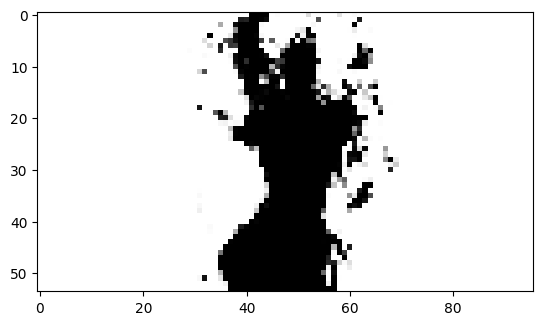

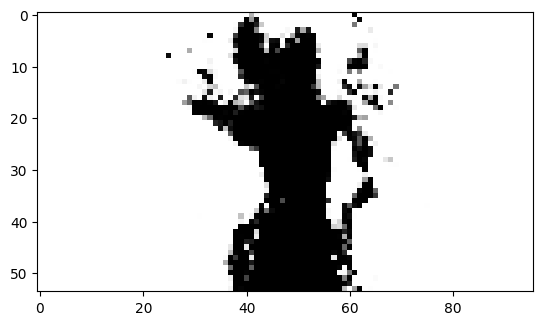

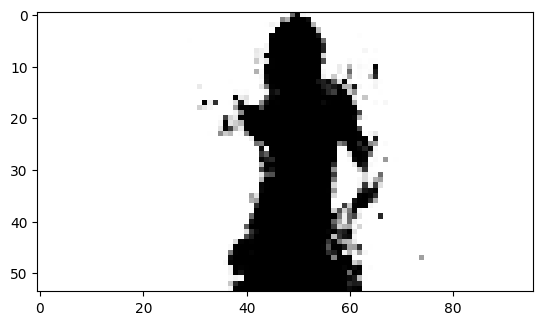

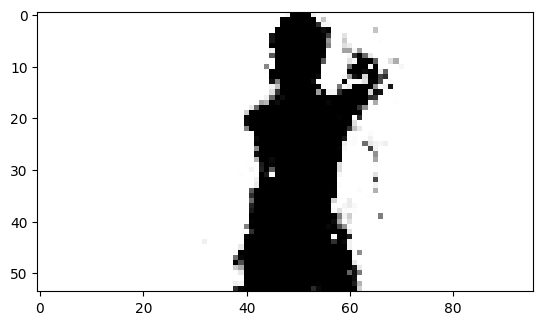

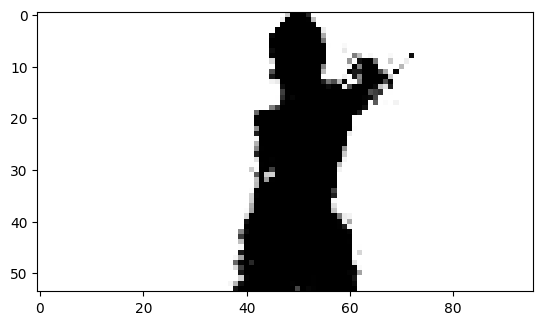

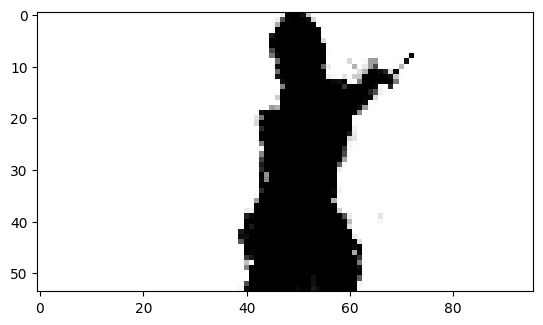

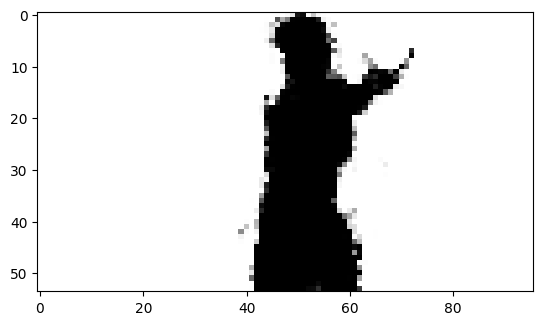

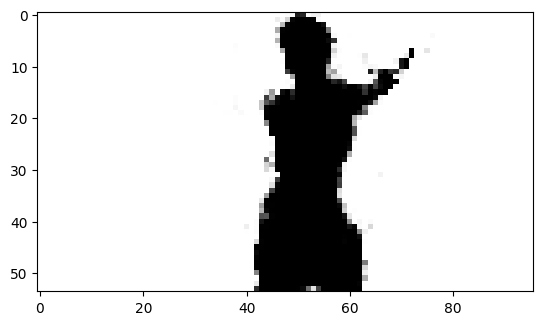

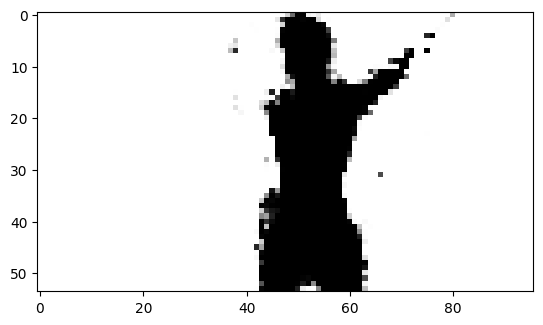

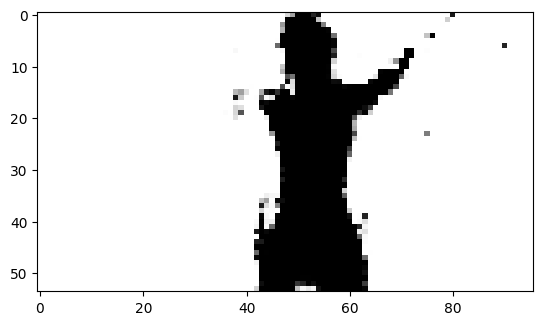

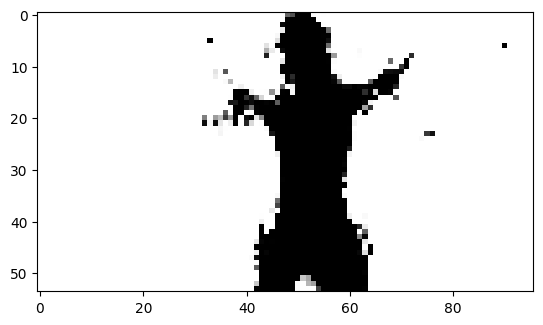

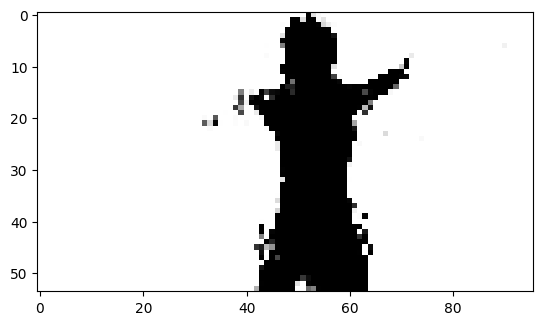

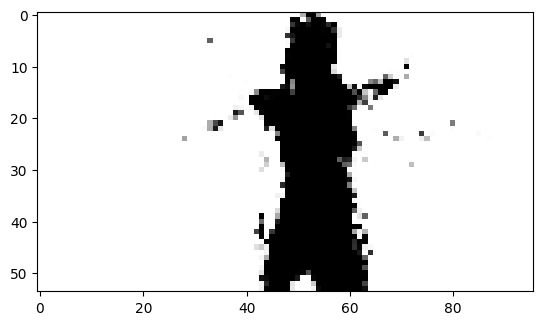

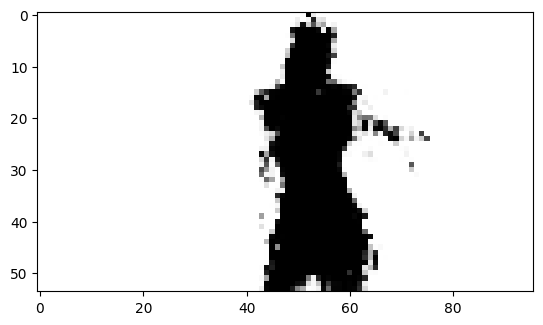

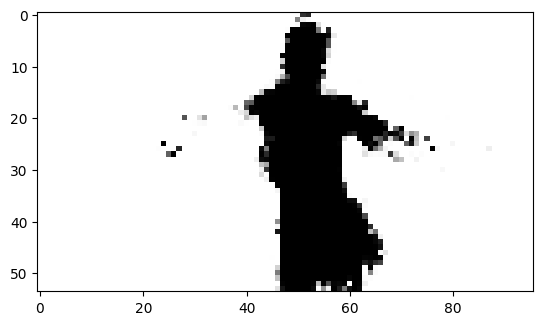

In [77]:
for vector in new_vectors:
    tensor = torch.from_numpy(vector)
    tensor = tensor.to(device)
    
    outputs = autoencoder_model.decoder(tensor)
    outputs = torch.reshape(outputs,(1,54,96)).cpu().detach().squeeze()

    plt.imshow(outputs, cmap="gray")
    plt.show()

In [78]:
generated_images_folder = 'generated_images'
os.makedirs(generated_images_folder, exist_ok=True)

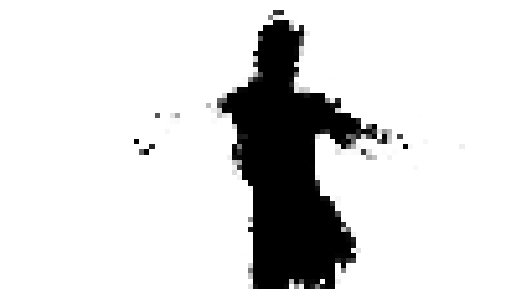

In [79]:
for i in range(len(new_vectors)):
    vector = new_vectors[i]
    tensor = torch.from_numpy(vector)
    tensor = tensor.to(device)
    
    outputs = autoencoder_model.decoder(tensor)
    outputs = torch.reshape(outputs,(1,54,96)).cpu().detach().squeeze()
    file_path = os.path.join(generated_images_folder, f'generated_image_{i+1}.jpg')
    
    plt.imshow(outputs, cmap="gray")
    plt.axis('off')
    plt.savefig(file_path)

# NEW Model

In [41]:
class SimpleLSTMModelV2(nn.Module):
    def __init__(self, input_dim, num_units, num_layers):
        super(SimpleLSTMModelV2, self).__init__()
        self.lstm = nn.LSTM(input_dim, num_units, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(num_units, input_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        # print(x.shape)
        x = self.fc(x[:, -1, :])
        return x

In [42]:
lstm_model_v2 = SimpleLSTMModelV2(input_dim, num_units, 3)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model_v2.parameters())

In [43]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [44]:
lstm_model_v2.to(device)

SimpleLSTMModelV2(
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=128, bias=True)
)

In [45]:
device

device(type='mps')

In [46]:
with open(results_rnn_file, 'w') as f:
    f.write('Epoch,Loss\n')

In [47]:
epochs = 30
print('====Training start====')
for epoch in range(epochs):
    train_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()

        inputs = inputs.to(device)  

        outputs = lstm_model_v2(inputs)
        loss = criterion(outputs.cpu(), targets)
        loss.backward()

        # nn.utils.clip_grad_norm_(lstm_model_v2.parameters(), max_norm=1.0)
        
        train_loss += loss.item()        
        optimizer.step()
    
    if epoch % 5 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
        with open(results_rnn_file, 'a') as f:
            f.write(f'{epoch+1},{train_loss:.4f}\n')
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 47344.9418
====> Epoch: 5 Average loss: 25023.6517
====> Epoch: 10 Average loss: 20293.9477
====> Epoch: 15 Average loss: 18128.6219
====> Epoch: 20 Average loss: 16867.8574
====> Epoch: 25 Average loss: 16041.3158
====Training finish====


In [218]:
def generate_vectors_v2(model, initial_input, num_predictions):
    model.eval()
    generated = []
    input_seq = initial_input
    with torch.no_grad():
        for _ in range(num_predictions):
            input_seq_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            input_seq_tensor = input_seq_tensor.to(device)

            next_vector = model(input_seq_tensor)
            next_vector = next_vector.squeeze(0).cpu().numpy()
            # save vector 
            generated.append(next_vector)
            # generate add to input new vector
            input_seq.append(next_vector)
    return generated

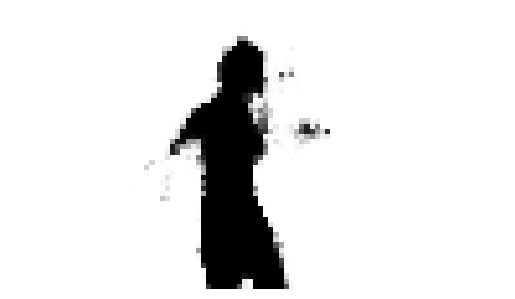

In [220]:
test_input_vector = [df.iloc[100]['encode_vector']]
images_count = 100
new_vectors = generate_vectors_v2(lstm_model, test_input_vector, images_count)
generated_images_folder = 'generated_images'
os.makedirs(generated_images_folder, exist_ok=True)
for i in range(len(new_vectors)):
    vector = new_vectors[i]
    tensor = torch.from_numpy(vector)
    tensor = tensor.to(device)
    
    outputs = autoencoder_model.decoder(tensor)
    outputs = torch.reshape(outputs,(1,54,96)).cpu().detach().squeeze()
    file_path = os.path.join(generated_images_folder, f'generated_image_{i+1}.jpg')
    
    plt.imshow(outputs, cmap="gray")
    plt.axis('off')
    plt.savefig(file_path)